# Beginning Machine Learning with scikit-learn

## Learning about Humans learning ML

For a start at this lesson, we will load the massaged and moderately feature engineered data that we left off with in the last lesson.  The `X` and `y` for this cleaned up dataset are saved in this repository as separate CSV files.

In [1]:
from src.setup import *

In [2]:
X = pd.read_csv('data/HumansLearning_X.csv', index_col=0)
y = pd.read_csv('data/HumansLearning_y.csv', squeeze=True, header=None)

## Feature importances

Best practice in machine learning is to keep training and testing sets separate. With sufficiently large datasets, it makes little difference in the trained model parameters whether or how train/test observations are separated. But this is a small dataset, and also reflects a somewhat unique event (many students will learn about machine learning through many channels, but this particular tutorial, with a particular instructor, at a particular conference, will not necessarily generalize to all those channels).

Therefore, in order to see simply what is the "best possible" decision tree for this dataset, I deliberately "overfit" by including all the observations in the model.  This improves predictive power somewhat, as one would expect.

The feature importances identified by this classifier are not the same as—nor even necessarily particularly similar to—those that would be produced by other classifiers.

In [3]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X, y)
tree.score(X, y)

0.8103448275862069

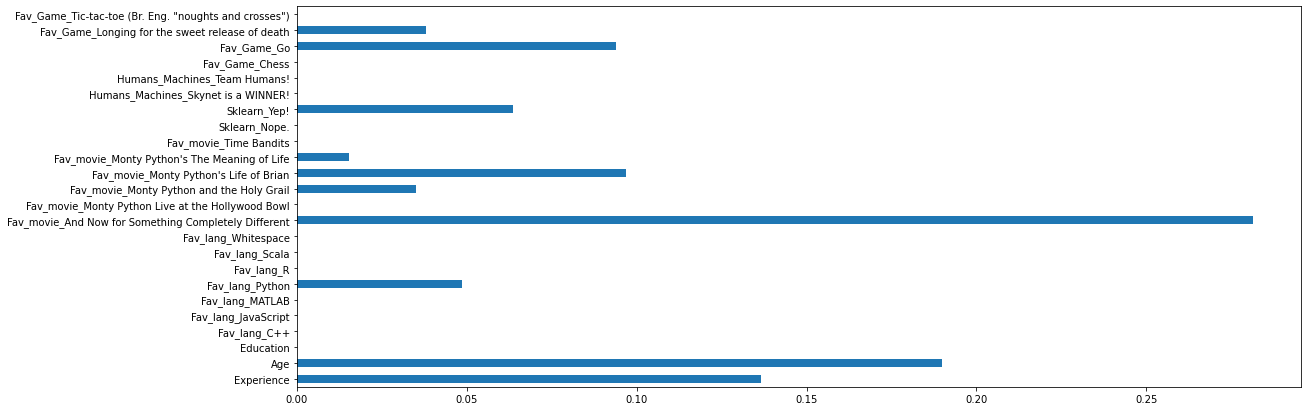

In [4]:
%matplotlib inline
pd.Series(tree.feature_importances_, index=X.columns).plot.barh(figsize=(18,7));

## Cut points in a Decision Tree

As well as seeing what features are most important in this trained model, we can use a lovely utility method in `sklearn.tree` to display the entire tree and its decision cuts.

In [5]:
# Figure out where graphviz executable lives
dotpath = !which dot

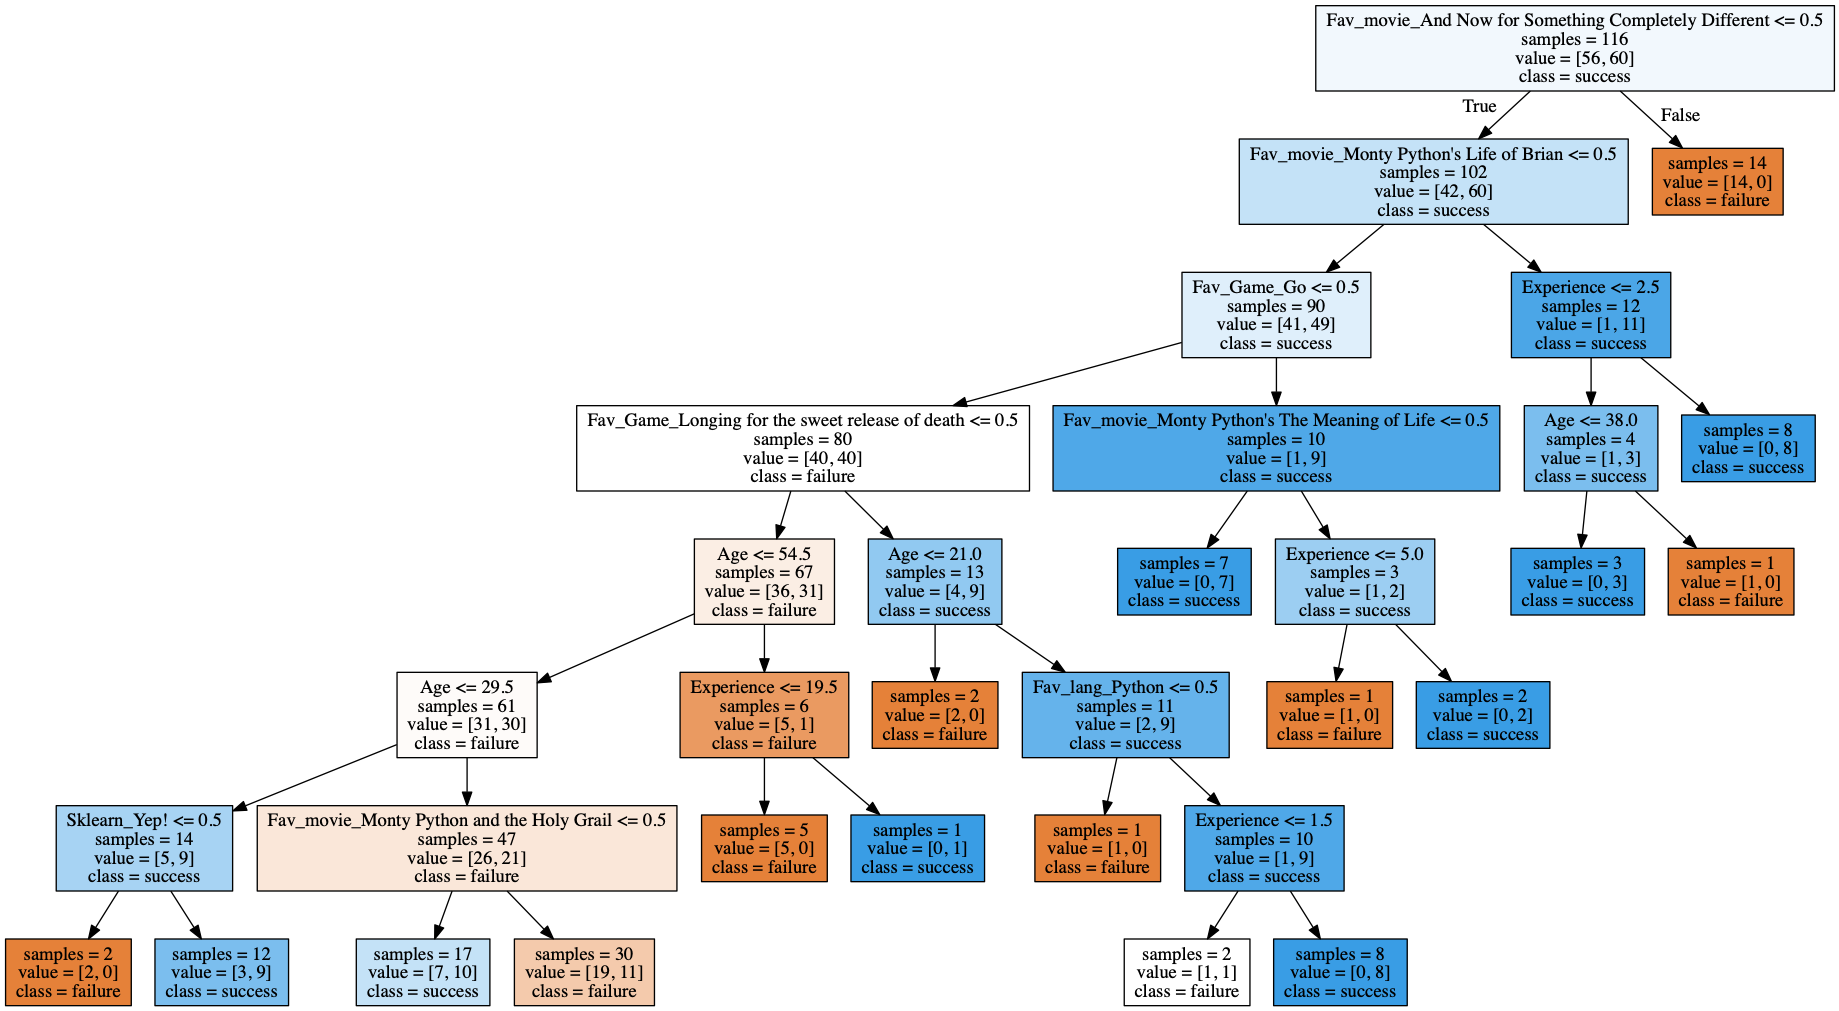

In [6]:
# Generate cut point diagram
from sklearn.tree import export_graphviz
import sys, subprocess
from IPython.display import Image

export_graphviz(tree, feature_names=X.columns, class_names=['failure','success'],
                out_file='ml-good.dot', impurity=False, filled=True)
subprocess.check_call([dotpath[0],'-Tpng','ml-good.dot','-o','ml-good.png'])
Image('ml-good.png')

In the diagram, blue branches reflect those respondents who found the tutorial more successful, and orange branches those who found it less so. The saturation of the displayed boxes reflects the strength of that decision branch.

As seems obvious in retrospect, the fans of [*And Now for Something Completely Different*](https://en.wikipedia.org/wiki/And_Now_for_Something_Completely_Different) really did not like my tutorial very much. I probably should have provided a disclaimer at the beginning of the session. Years of Python experience is a slightly more important feature, but it follows an oddly stratified pattern wherein several different ranges of years show positive or negative effects—it's not linear.

And of course, [*Time Bandits*](https://en.wikipedia.org/wiki/Time_Bandits) was not a Monty Python film at all: it is a Terry Gilliam film that happened to cast a number of Monty Python cast members. What on earth were those respondents thinking?!



## A common API

I have mentioned in the introduction to this course that one of the great virtues of scikit-learn is its use of a common API across many different model classes.  For practice, let us look at a typical pattern again for `DecisionTreeClassifier` followed by the same pattern for `DummyClassifier`.  This latter is a good sanity check of how well you might predict without really trying and/or without doing anything particularly meaningful to train against the data.

There are several "strategies" that `DummyClassifier` might use (not all listed):

* `stratified`: generates predictions by respecting the training set’s class distribution.
* `most_frequent`: always predicts the most frequent label in the training set.
* `uniform`: generates predictions uniformly at random.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [8]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.5862068965517241

In [9]:
from sklearn.dummy import DummyClassifier
for strategy in ['most_frequent', 'stratified', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strategy, random_state=2)
    dummy.fit(X_train, y_train)
    score = dummy.score(X_test, y_test)
    print("{:<15}| score = {:.3f}".format(strategy, score))

most_frequent  | score = 0.414
stratified     | score = 0.517
prior          | score = 0.414
uniform        | score = 0.621


To our alarm, the algorithm we thought was showing some promise is little better than random classification; in fact it is worse than one variety of the random strategy.$^1$

There are a couple problems that are exposed here.  One is simply that the dataset is much too small to be a good fit for machine learning algorithms.  Discovering subtle patterns usually requires fairly extensive data.  Another problem *may be* that there simply is not a strong enough pattern in the data to meaningfully extract conclusions.

<hr/>

<small><i>$^1$A confession is in order: I tried a few different `random_state` values to find one that produced this imbalance.  But *only a few* and the fact any random seed might produce better results is not a good sign.</i></small>

### A more encouraging dataset

For demonstration purposes, I have also constructed a *fake* dataset by replicating the information in the whimsical data 50 times, but then randomly biasing features to be more predictive.  This is terrible practice for anything real, of course.  This gives us 5800 rows and data with the same features, but more predictive power, just as a pedagogical dataset.

In [10]:
import pandas as pd
fake_learning = pd.read_csv('data/FakeLearning.csv')
X_fake = fake_learning.drop("Success", axis=1)
y_fake = fake_learning.Success

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_fake, y_fake, random_state=1)

In [12]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.8275862068965517

In [13]:
from sklearn.dummy import DummyClassifier
for strategy in ['most_frequent', 'stratified', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strategy, random_state=2)
    dummy.fit(X_train, y_train)
    score = dummy.score(X_test, y_test)
    print("{:<15}| score = {:.3f}".format(strategy, score))

most_frequent  | score = 0.603
stratified     | score = 0.522
prior          | score = 0.603
uniform        | score = 0.506


One thing we notice with this change to the size and (artificial) predictiveness of the data is that `DummyClassifier` stays pretty much the same, and `DecisionTreeClassifier` gets a lot better.

## Quick comparison of many classifiers in scikit-learn

> **"The first 90 percent of the code accounts for the first 90 percent of the development time. The remaining 10 percent of the code accounts for the other 90 percent of the development time."** –Tom Cargill, Bell Labs

Having done the 90% of our work that was needed for data cleanup, the next 90% can be spent on model selection. Better hyperparameters than those chosen below (mostly defaults) are likely to identify better fits. Moreover, the few classifiers listed are by no means all of those in scikit-learn.

This code is mostly based on the Scikit-learn [Classifier Comparison](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

> Code source: Gaël Varoquaux & Andreas Müller<br/>
> Modified for documentation by Jaques Grobler<br/>
> License: BSD 3 clause

In [14]:
# Use the large (but fake) dataset
X_train, X_test, y_train, y_test = train_test_split(
                    X_fake, y_fake, test_size=0.5, random_state=1)

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

classifiers = {
    "Dummy"        : DummyClassifier(strategy='uniform', random_state=2),
    "KNN(3)"       : KNeighborsClassifier(3), 
    "RBF SVM"      : SVC(gamma=2, C=1), 
    "Decision Tree": DecisionTreeClassifier(max_depth=7), 
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=10, max_features=4), 
    "Neural Net"   : MLPClassifier(alpha=1), 
    "AdaBoost"     : AdaBoostClassifier(),
    "Naive Bayes"  : GaussianNB(), 
    "QDA"          : QuadraticDiscriminantAnalysis(),
    "Linear SVC"   : LinearSVC(),
    "Linear SVM"   : SVC(kernel="linear"), 
    "Gaussian Proc": GaussianProcessClassifier(1.0 * RBF(1.0)),
}

Once we have moved to a larger dataset (of 5k items) some models can take considerable time to train.  This can often become a significant practical consideration in choices.  MoreoverHappily, prediction time is almost always vastly quicker than training time.  It is often worthwhile to sink hours, or days, into training times if it will produce better models; those models can usually be used for predictions in orders of magnitude less time (usually with better big-O efficiency than training).

Let us first compare the first few classifiers in the dictionary we define above:

In [17]:
from time import time
nfast = 10      # Don't run the very slow ones
head = list(classifiers.items())[:nfast]

for name, classifier in head:
    start = time()
    classifier.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    score = classifier.score(X_test, y_test)
    score_time = time()-start
    print("{:<15}| score = {:.3f} | time = {:,.3f}s/{:,.3f}s".format(name, score, train_time, score_time))

Dummy          | score = 0.508 | time = 0.001s/0.001s
KNN(3)         | score = 0.588 | time = 0.008s/0.094s
RBF SVM        | score = 0.621 | time = 0.452s/0.308s
Decision Tree  | score = 0.821 | time = 0.005s/0.001s
Random Forest  | score = 0.845 | time = 0.018s/0.004s
Neural Net     | score = 0.531 | time = 0.281s/0.006s
AdaBoost       | score = 0.840 | time = 0.118s/0.020s
Naive Bayes    | score = 0.806 | time = 0.002s/0.004s
QDA            | score = 0.634 | time = 0.017s/0.002s
Linear SVC     | score = 0.643 | time = 0.125s/0.002s


Many classifiers scale training time linearly with sample size.  So for those fortunate ones, training on a million observations will simply take 100x as long as training on ten thousand observations.  However, a few classifiers have worse big-O complexities than this.  SVC with a linear kernel is $O(N^2)$ and Gaussian Process is $O(N^3)$, making them generally infeasible for large training sets.  Interestingly, `LinearSVC` implements an SVC linear kernel differently, making it $O(N)$ complexity, but also resulting in dramatically worse results in many tests I have tried.

```
Dummy          | score = 0.508 | time = 0.00s/0.00s
KNN(3)         | score = 0.588 | time = 0.01s/0.03s
RBF SVM        | score = 0.621 | time = 0.42s/0.19s
Decision Tree  | score = 0.821 | time = 0.02s/0.00s
Random Forest  | score = 0.844 | time = 0.02s/0.00s
Neural Net     | score = 0.807 | time = 0.20s/0.03s
AdaBoost       | score = 0.840 | time = 0.12s/0.02s
Naive Bayes    | score = 0.806 | time = 0.00s/0.00s
QDA            | score = 0.569 | time = 0.06s/0.00s
Linear SVC     | score = 0.773 | time = 0.141s/0.001s
Linear SVM     | score = 0.819 | time = 166.78s/0.05s
Gaussian Proc  | score = 0.621 | time = 3,334.28s/0.31s
```

Within the range of classifiers, all have advantages against some datasets.  Other than `DummyClassifier` none of the classifiers lack advantages for at least some range of datasets.  The scores we found against the artificially expanded and weighted data suggests one we might look at more closely for the actual data.

## Feature importances revisited

One of the classifiers that did well in our playing around is `AdaBoostClassifier`.  Unfortunately, when we return to the initial smaller and unskewed dataset, it has the same generally rather low score as `DecisionTreeClassifier`.  It may simply be that the underlying data has little predictive value in this case.  If the target is genuinely independent/orthogonal to all the other features, there is nothing a machine learning model can predict. 

But one thing nice about `AdaBoostClassifier` is that it provides feature importances like `DecisionTreeeClassifier` and `RandomForestClassifier`.  This produces about the same predictive value, while focusing on very different features.

In [18]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

X = pd.read_csv('data/HumansLearning_X.csv', index_col=0)
y = pd.read_csv('data/HumansLearning_y.csv', squeeze=True, header=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [19]:
# Remember the old not-that-great score
tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.5862068965517241

In [20]:
# The Adaboost score is simlarly not-that-great
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
ab.score(X_test, y_test)

0.5517241379310345

Let's fit on the entire data set again, as before.  And look at the feature importances in contrast between the models.

In [21]:
tree = DecisionTreeClassifier(max_depth=7, random_state=0).fit(X, y)
pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False).head(7)

Fav_movie_And Now for Something Completely Different    0.281513
Age                                                     0.190001
Experience                                              0.136583
Fav_movie_Monty Python's Life of Brian                  0.096952
Fav_Game_Go                                             0.093993
Sklearn_Yep!                                            0.063728
Fav_lang_Python                                         0.048665
dtype: float64

In [22]:
ab = AdaBoostClassifier().fit(X, y)
pd.Series(ab.feature_importances_, index=X.columns).sort_values(ascending=False).head(7)

Age                                                0.48
Experience                                         0.22
Education                                          0.06
Fav_movie_Monty Python's Life of Brian             0.04
Fav_Game_Longing for the sweet release of death    0.02
Fav_lang_C++                                       0.02
Fav_lang_JavaScript                                0.02
dtype: float64

An interesting result here is that AdaBoost produces much more intuitive weights than does a decision tree.  Decision tree puts relatively equal weights on many features, most of which we would not guess are important.  AdaBoost puts high weights on just a couple features, and very little on any others., and those are the ones that a human would guess are likely to be important.  This result may not apply across all datasets, but it probably will in many.

The documentation describes AdaBoost like this:

> An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. This class implements the algorithm known as AdaBoost-SAMME. 

## Multiclass classification

For simplification, we looked at a binary classification problem so far, and one with somewhat questionable underlying predictive possibilities.  Let us use a more real-world example that is included with scikit-learn, a dataset of handwritten digits, similar to the MNIST dataset often used to test the strength of different models.

> This dataset is made up of 1797 8x8 images. Each image, like the one shown below, is of a hand-written digit. In order to utilize an 8x8 figure like this, we’d have to first transform it into a feature vector with length 64.

Reading the description, even though we normally think of an image as a $width \times height$ array, the representation here is simply of independent features for each pixel of the image.

To model this we will use `LogisticRegression`.  Despite its name, this model is a classifier not a regressor.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
digits = load_digits()

Let us understand the nature of the data.

In [24]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [25]:
print("Features:",
      digits.data.shape, 
      digits.data.dtype, 
      "\n  Target:",
      digits.target.shape, 
      digits.target.dtype)

Features: (1797, 64) float64 
  Target: (1797,) int64


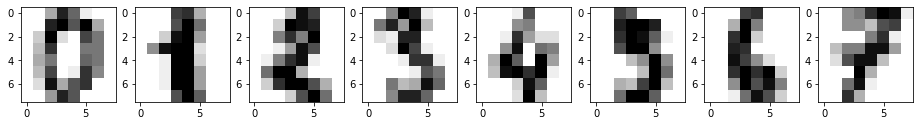

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 8, figsize=(16, 2))
for n in range(8):
    ax[n].imshow(digits.images[n], cmap=plt.cm.gray_r)
plt.show()

## A multiclass confusion matrix

In a binary classification problems, the confusion matrix has a shape of (2, 2). In a multi-class problem, the confusion matrix has a shape (n_classes, n_classes) to show the correct vs incorrect classification counts for each class versus every other class.

A perfect confusion matrix has positive main diagonal and zeros elsewhere.

In [27]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)

# Perform a logistic regression
lr = LogisticRegression().fit(X_train, y_train)

# Make predictions against the test set
pred = lr.predict(X_test)

# Find the accuracy of the predictions against the true classes
print("accuracy: %0.3f" % accuracy_score(y_test, pred))

# Show the confusion matrix
print("confusion matrix:")
print(confusion_matrix(y_test, pred))

accuracy: 0.951
confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  1 40  3  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  1  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  0  0  1  0  0  1 45]]


We can use the [`mglearn` helper package](https://github.com/amueller/mglearn), used by *Introduction to Machine Learning with Python*, to present these results in a beautified way.  This nice, Free Software package from sckit-learn core developer Andreas Mueller has a number of convenient utilities, and is included in the archive for this course.  You might want to check the original repository to see if he has updated it since it was bundled here.

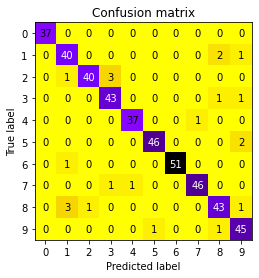

In [28]:
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), 
                                     xlabel='Predicted label', 
                                     ylabel='True label',
                                     xticklabels=digits.target_names, 
                                     yticklabels=digits.target_names,
                                     cmap=plt.cm.gnuplot_r, 
                                     fmt="%d")    

plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.93      0.91        43
           2       0.98      0.91      0.94        44
           3       0.91      0.96      0.93        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       1.00      0.98      0.99        52
           7       0.98      0.96      0.97        48
           8       0.91      0.90      0.91        48
           9       0.90      0.96      0.93        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



## Prediction probabilities

Most classification models produce not only a specific class prediction, but also a probability of each class membership.  The actual prediction is simply the most likely class according to the model.  For example, looking at one of the digit images, we can see the likelihood—according to the model—that it represents each possible value.

3 | 99.9998%
7 | 0.0002%
2 | 0.0000%
9 | 0.0000%
8 | 0.0000%
1 | 0.0000%
5 | 0.0000%
0 | 0.0000%
4 | 0.0000%
6 | 0.0000%


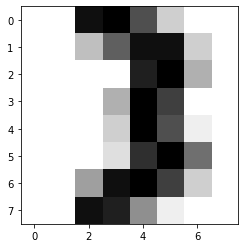

In [50]:
from random import randint
n = randint(0,len(digits.images))
plt.imshow(digits.images[n], cmap=plt.cm.gray_r)
probs = pd.Series(lr.predict_proba(digits.data[n:n+1]).flatten()) 
for digit, prob in probs.sort_values(ascending=False).iteritems():
    print(digit, "| %.4f%%" % (100*prob))

## Classifier boundary comparison

On of the main tradeoffs among classifiers (and also among regressors) is between complexity and generalization.  For example, `LinearRegression` and `LogisticRegression` are very simple models that cannot fit complicated relationships. On the other hand, it is hard to overfit a LinearRegression.

In contrast, `KNeighborsClassifier` is not very general.  At the extreme, with one neighbor, the model essentially just memorizes the data.  On the other hand, for overly large `n_neighbors`, the model will tend to only predict the most commonly occurring label.  That said, there are many datasets for which K nearest neighbor is an excellent choice.

The below code is taken directly from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).  It is a nice way to explore and visually summarize the different decision boundaries that various classifiers product.

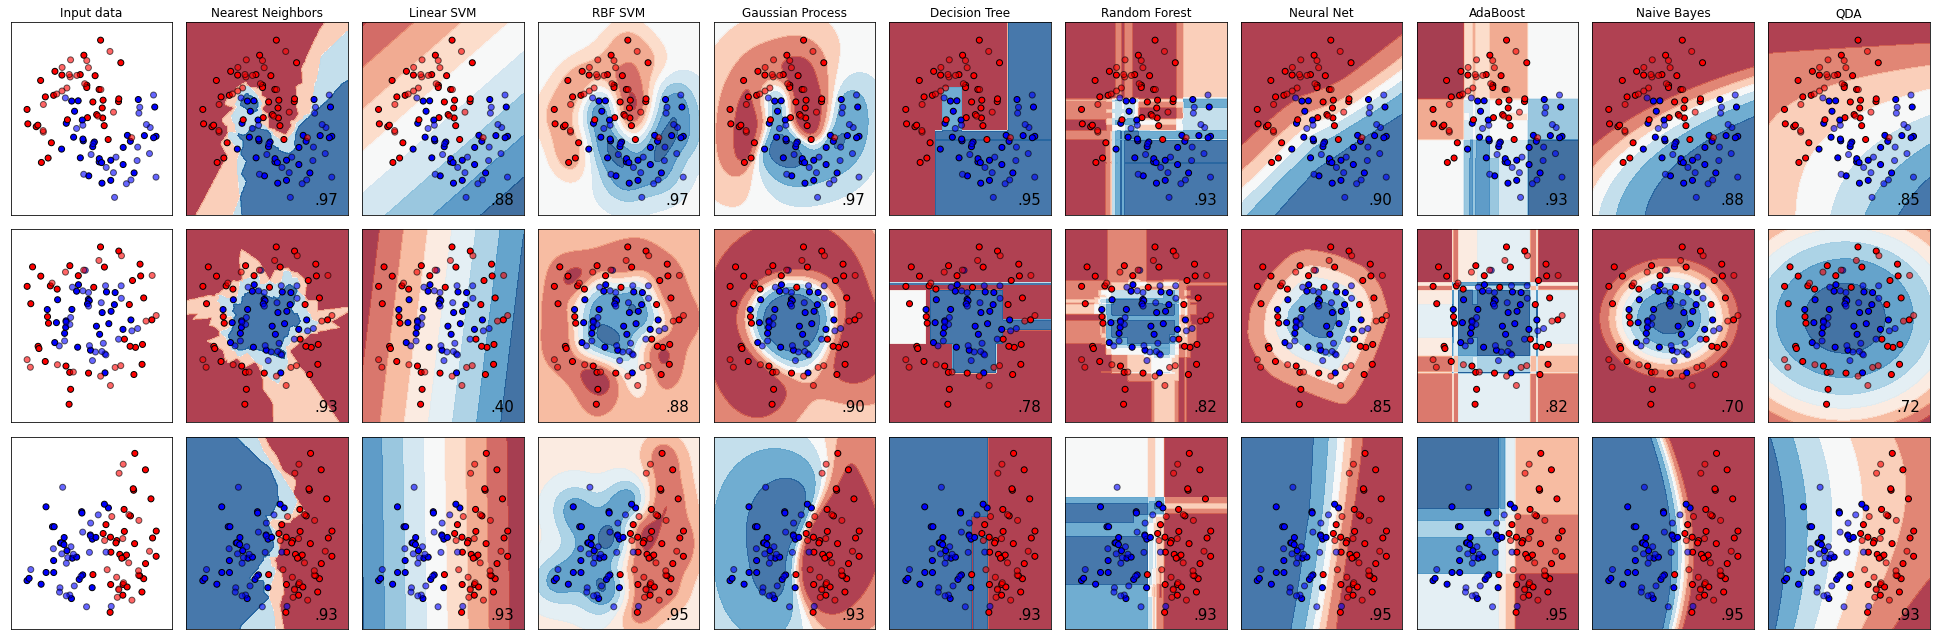

<Figure size 432x288 with 0 Axes>

In [32]:
%run src/classifier_comparison.py

## Next lesson

**Regression**: In the current lessson we explored the classifer APIs and looked at a few examples of different datasets and different classifiers.  We had a passing exposure to hyperparameters and validation, but the bulk of those topics come in later lessons.  In the next lesson we will stay within supervised learning, but look at regression rather than classification.

<a href="Regression.ipynb"><img src="img/open-notebook.png" align="left"/></a>